# Netflix Movies and TV Shows Data Analysis

### Importing Libraries and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Load the data
data = pd.read_csv('data/netflix_titles.csv')
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Data Cleaning

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [4]:
data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [5]:
data.dropna(inplace=True)

In [6]:
#data['listed_in'] = data['listed_in'].apply(lambda x: x.split(', '))

# Explode the list into separate rows
data_exploded = data.explode('listed_in')

data_exploded.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...
24,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...


## Text Processing on Description

- Action
- Comedy
- Drama
- Fantasy
- Horror
- Mystery
- Romance
- Thriller
- Western

In [7]:
import nltk
from nltk.tokenize import word_tokenize

# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Tokenization function
def tokenize_text(text):
    return word_tokenize(text)

# Assuming `data` is a pandas DataFrame
mined_data = {'title': [], 'Tokens': [], 'listed_in': [], 'country': [], 'type': [], 'rating': []}

# Iterating over the DataFrame
for index, row in data_exploded.iterrows():
    # Tokenize the description
    words = tokenize_text(row['description'])
    
    # lowercase 
    words = [word.lower() for word in words]
    
    # Stopword removal
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # remove punctuation
    import re
    words = [re.sub(r'\W+', '', word) for word in words if word.isalpha()]
    
    # lemmentize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # one, two, three, four, five, six, seven, eight, nine, ten removed
    words = [word for word in words if word not in ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']]
    
    # modal verbs removed
    words = [word for word in words if word not in ['can', 'could', 'may', 'might', 'must', 'will', 'would', 'shall', 'should', 'take', 'find','help', 'get']]
    
    # Update the 'data' dataframe with the tokenized description
    mined_data['title'].append(row['title'])
    mined_data['Tokens'].append(words)
    mined_data['listed_in'].append(row['listed_in'])
    mined_data['country'].append(row['country'])
    mined_data['type'].append(row['type'])
    mined_data['rating'].append(row['rating'])
    

# Create a new DataFrame with the tokenized description
df = pd.DataFrame(mined_data)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mahshid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mahshid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mahshid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,title,Tokens,listed_in,country,type,rating
0,Sankofa,"[photo, shoot, ghana, american, model, slip, b...","Dramas, Independent Movies, International Movies","United States, Ghana, Burkina Faso, United Kin...",Movie,TV-MA
1,The Great British Baking Show,"[talented, batch, amateur, baker, face, compet...","British TV Shows, Reality TV",United Kingdom,TV Show,TV-14
2,The Starling,"[woman, adjusting, life, loss, contends, feist...","Comedies, Dramas",United States,Movie,PG-13
3,Je Suis Karl,"[family, murdered, terrorist, bombing, young, ...","Dramas, International Movies","Germany, Czech Republic",Movie,TV-MA
4,Jeans,"[father, man, love, insists, twin, son, marry,...","Comedies, International Movies, Romantic Movies",India,Movie,TV-14


In [35]:
data_exploded = data_exploded.explode('listed_in')

- df should be used for further analysis and visualization
- data_exploded should be used for prediction

In [36]:
# Drop 'International Movies' and 'International TV Shows' as they are not specific genre
data_exploded = data_exploded[data_exploded['listed_in'] != 'International Movies']
data_exploded = data_exploded[data_exploded['listed_in'] != 'International TV Shows']
data_exploded  = data_exploded[data_exploded['listed_in'] != 'Independent Movies']


In [37]:
# add 'TV Dramas' to 'Dramas'
data_exploded['listed_in'] = data_exploded['listed_in'].replace({'TV Dramas': 'Dramas',
                                           'Action & Adventure': 'Action',
                                           'Romantic Movies': 'Romantics',
                                           'Children & Family Movies': 'Family',
                                           'Classic Movies': 'Classic',
                                           'Horror Movies': 'Horror',
                                           'Music & Musicals': 'Musical',
                                           'Sci-Fi & Fantasy': 'Fantasy',
                                           'Sports Movies': 'Sports',
                                           'LGBTQ Movies': 'LGBTQ',
                                           'Cult Movies': 'Classic',
                                           'Faith & Spirituality': 'Faith',
                                           'Anime Features': 'Anime',
                                           'TV Comedies': 'Comedies',
                                           'TV Mysteries': 'Mystery',
                                           'TV Sci-Fi & Fantasy': 'Fantasy',
                                           'TV Thrillers': 'Thrillers',
                                           'TV Horror': 'Horror',
                                           'TV Action & Adventure': 'Action',
                                           'Reality TV': 'Reality',
                                           'Teen TV Shows': 'Teen',
                                           'Classic & Cult TV': 'Classic',
                                           'Science & Nature TV': 'Science',
                                           'Crime TV Shows': 'Crime',
                                           'Romantic TV Shows': 'Romantics',
                                           'British TV Shows': 'British',
                                           'Korean TV Shows': 'Korean',
                                           'Spanish-Language TV Shows': 'Spanish',
                                           "Kids' TV": 'Family',
                                           'Stand-Up Comedy & Talk Shows': 'Stand-Up Comedy',
                                           'Anime Series': 'Anime',
                                           'Science': 'Docuseries',
                                           })


In [38]:
data_exploded["listed_in"].value_counts()

listed_in
Dramas, International Movies                        336
Stand-Up Comedy                                     287
Comedies, Dramas, International Movies              257
Dramas, Independent Movies, International Movies    243
Children & Family Movies, Comedies                  179
                                                   ... 
British TV Shows, Classic & Cult TV, TV Comedies      1
Action & Adventure, Comedies, Horror Movies           1
Action & Adventure, Documentaries, Sports Movies      1
Crime TV Shows, TV Dramas, TV Mysteries               1
Reality                                               1
Name: count, Length: 330, dtype: int64

### Word Frequency

In [11]:
# frequency of words in each genre
def word_genre_freq(dataframe):
    genre_word_frequency = {}
    for index, row in dataframe.iterrows():
        genre = row['listed_in']
        tokens = row['Tokens']
        if genre not in genre_word_frequency:
            genre_word_frequency[genre] = Counter()
        genre_word_frequency[genre].update(tokens)    
    return genre_word_frequency

In [12]:
genre_word_freq = word_genre_freq(df)

In [13]:
genre_word_freq["Action"].most_common(10)

[('agent', 21),
 ('terrorist', 16),
 ('team', 15),
 ('revenge', 13),
 ('group', 13),
 ('force', 13),
 ('mission', 12),
 ('cop', 12),
 ('cia', 10),
 ('daughter', 10)]

### Word Cloud Visualization

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# with the top 20 words in each genre

def plot_word_cloud(genre_word_freq, genres=None):  
    for genre, freq in genre_word_freq.items():
        if genre == genres:
            freq = dict(freq.most_common(20))
            wordcloud = WordCloud(width = 800, height = 800, 
                            background_color ='white', 
                            stopwords = set(stopwords.words('english'), ),
                            min_font_size = 10).generate_from_frequencies(freq)
    
            plt.figure(figsize = (8, 8), facecolor = None) 
            plt.imshow(wordcloud) 
            plt.axis("off") 
            plt.tight_layout(pad = 0) 
            plt.title(genre)
            plt.show()

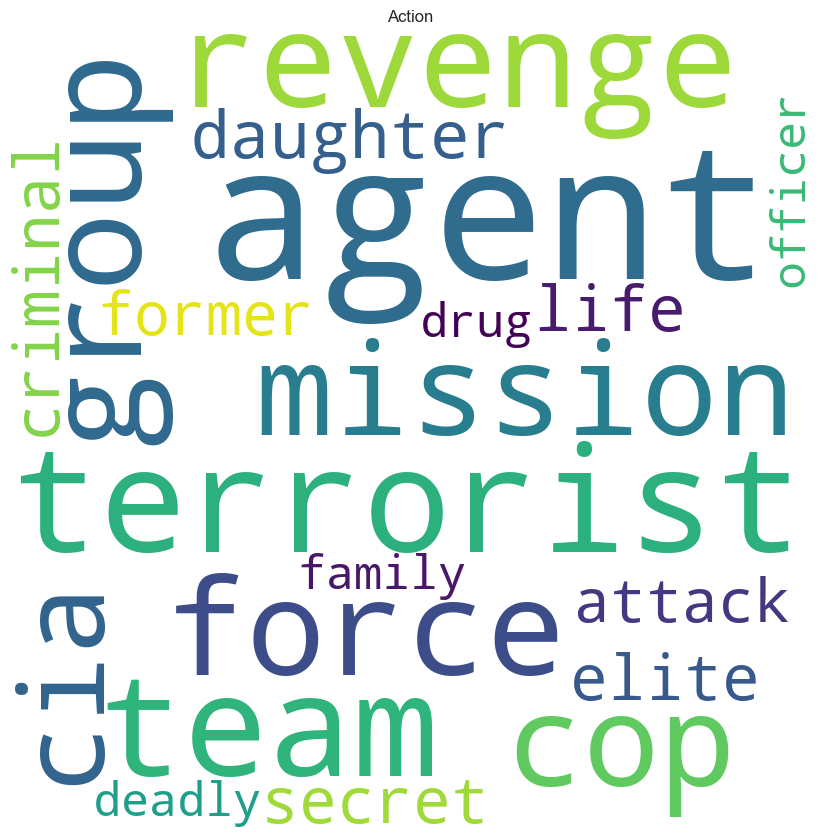

In [15]:
plot_word_cloud(genre_word_freq, genres='Action')

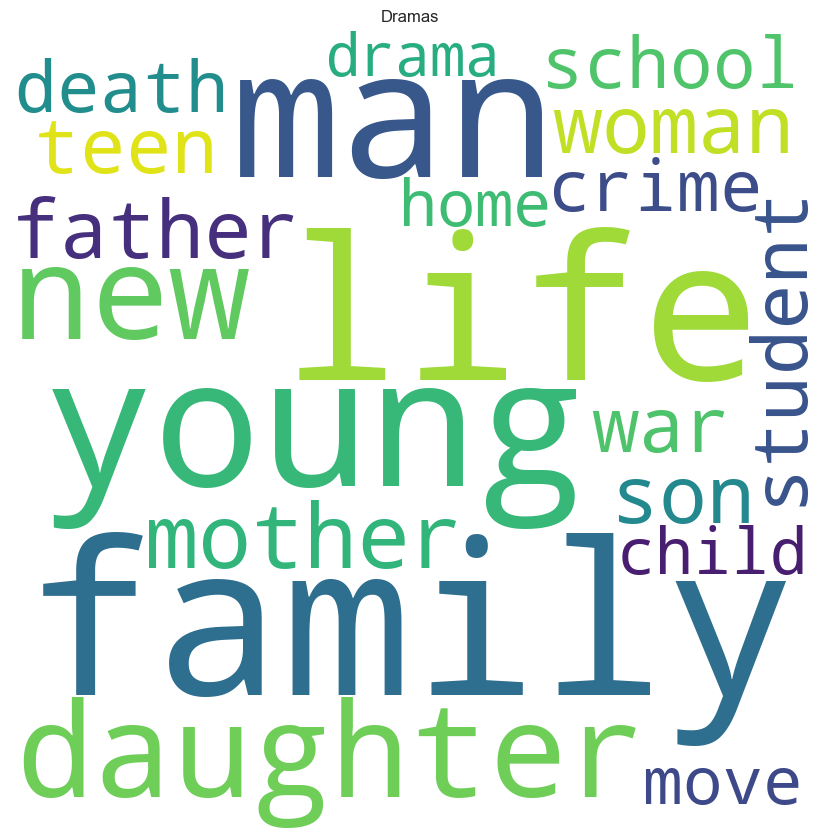

In [16]:
plot_word_cloud(genre_word_freq, genres='Dramas')

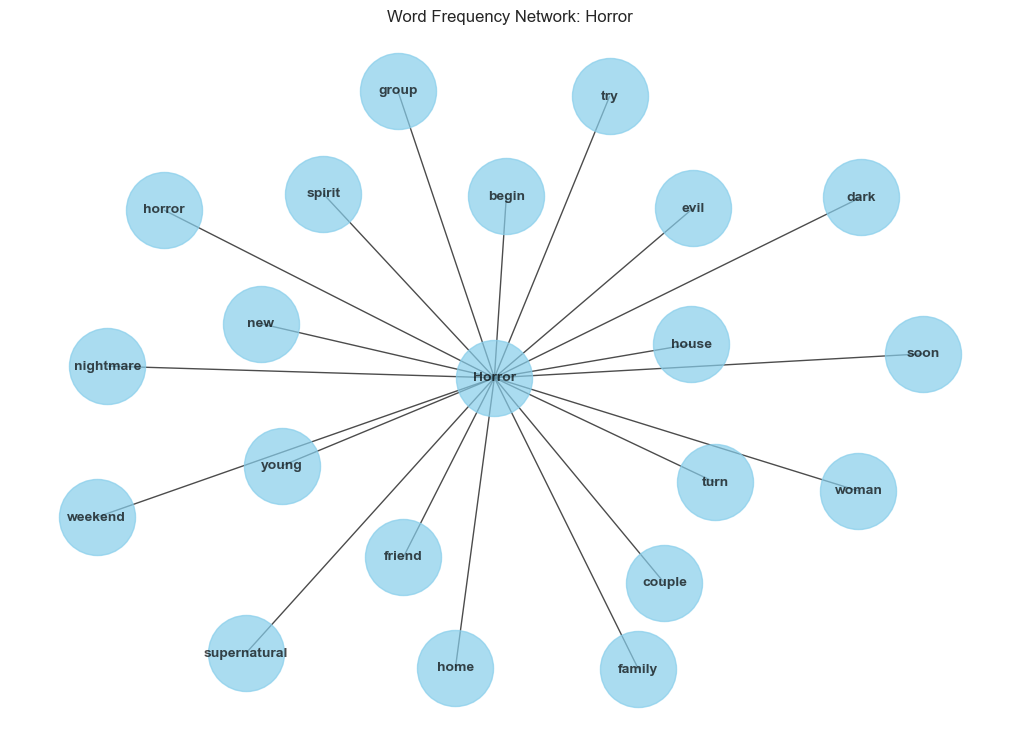

In [27]:
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
def create_network_graph(genre_word_freq, genres=None):
    G = nx.Graph()
    for genre, freq in genre_word_freq.items():
        if genre == genres:
            freq = dict(freq.most_common(20))
            if genre not in G:
                G.add_node(genre)
                for word, count in freq.items():
                    if word not in G:
                        G.add_node(word)
                    G.add_edge(genre, word, weight=count)
                    
    return G
genre = 'Horror'
g = create_network_graph(genre_word_freq, genres=genre)

pos_centered = nx.spring_layout(g, seed=42)
plt.figure(figsize=(10, 7))
nx.draw(g, pos_centered, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='black', width=1, alpha=0.7)
plt.title(f"Word Frequency Network: " + genre)
plt.show()
                    

### Shared Term 

In [28]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
import nltk
from nltk.corpus import stopwords
# Download stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Function to get top words for a genre
def get_top_words(genre, n=3):
    genre_tokens = [token for tokens in df[df['listed_in'].str.contains(genre)]['Tokens'] for token in tokens]
    word_counts = Counter(genre_tokens)
    return [word for word, _ in word_counts.most_common(n) if word.lower() not in stop_words and len(word) > 2]
# Get unique genres
genres = df['listed_in'].str.split(', ').explode().unique()
# Create a graph
G = nx.Graph()
# Add nodes and edges
for genre in genres:
    G.add_node(genre, color='#FF9999', size=20)  # Add genre node
    top_words = get_top_words(genre)
    for word in top_words:
        G.add_node(word, color='#99CCFF', size=15)  # Add word node
        G.add_edge(genre, word)  # Add edge between genre and word
# Create a Pyvis network
net = Network(notebook=True, width="100%", height="600px", bgcolor="#FFFFFF", font_color="black")
# Add nodes to the Pyvis network
for node, attrs in G.nodes(data=True):
    net.add_node(node, color=attrs['color'], size=attrs['size'], title=node)
# Add edges to the Pyvis network
for edge in G.edges():
    net.add_edge(edge[0], edge[1])
# Show the network
net.show('shared_terms.html')

shared_terms.html


Genre similarity heatmap has been saved as 'genre_similarity_heatmap.png'.
Top 5 most similar genre pairs:
Independent Movies - Independent Movies: 1.00
Documentaries - Documentaries: 1.00
Family - Family: 1.00
TV Horror - TV Horror: 1.00
TV Mysteries - TV Mysteries: 1.00
Done


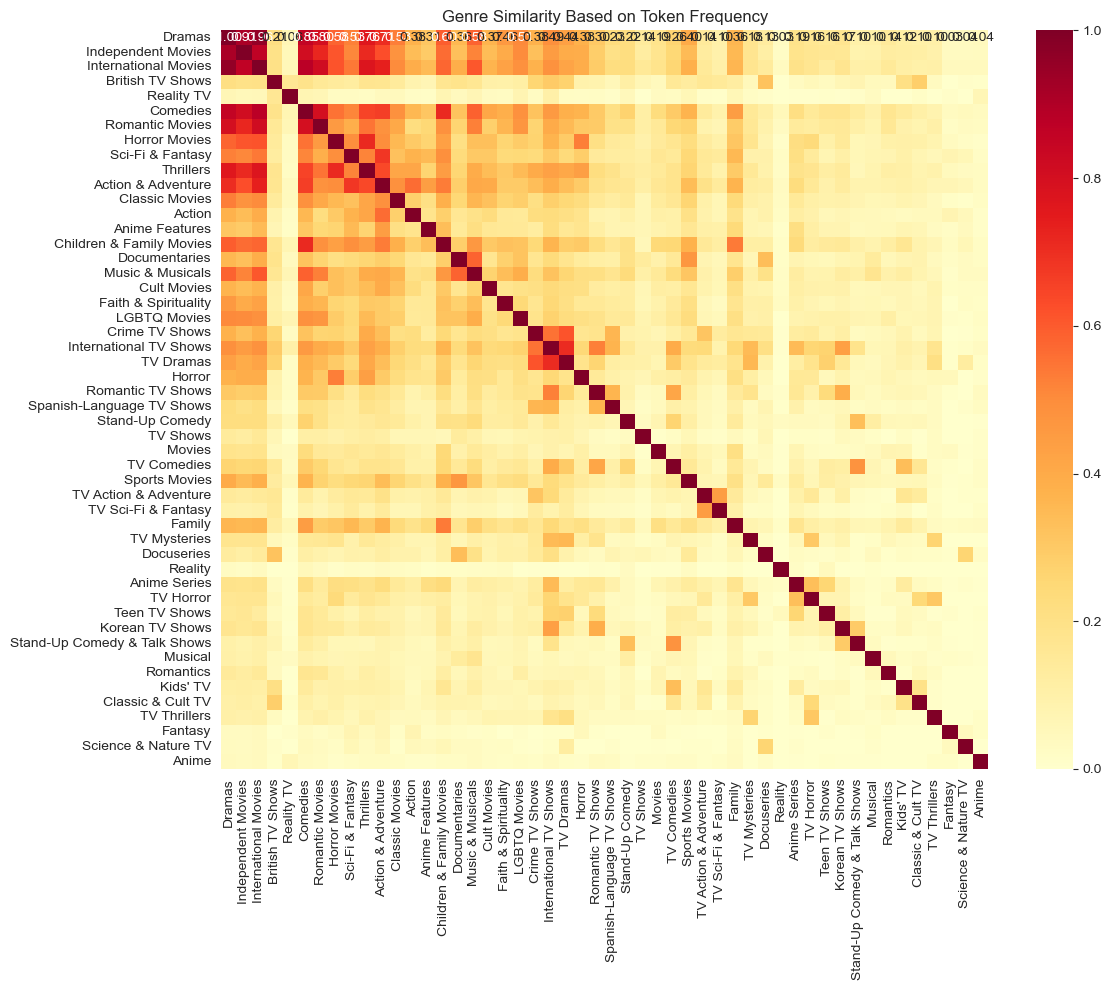

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Join the tokens into a single string for each row
df['Tokens_str'] = df['Tokens'].apply(' '.join)
# Get unique genres
genres = df['listed_in'].str.split(', ').explode().unique()
# Create a dictionary to store tokens for each genre
genre_tokens = {genre: [] for genre in genres}
# Populate the dictionary
for _, row in df.iterrows():
    for genre in row['listed_in'].split(', '):
        genre_tokens[genre].extend(row['Tokens'])
# Join tokens for each genre
genre_docs = {genre: ' '.join(tokens) for genre, tokens in genre_tokens.items()}
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Fit and transform the genre documents
tfidf_matrix = vectorizer.fit_transform(genre_docs.values())
# Calculate cosine similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
# Create a DataFrame for the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=genres, columns=genres)
# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Genre Similarity Based on Token Frequency')
plt.tight_layout()
plt.savefig('genre_similarity_heatmap.png')
plt.close()
print("Genre similarity heatmap has been saved as 'genre_similarity_heatmap.png'.")
# Display the top 5 most similar genre pairs
similarity_series = similarity_df.unstack()
similarity_series = similarity_series[similarity_series < 1.0]  # Remove self-similarities
top_5_similar = similarity_series.nlargest(5)
print("\
Top 5 most similar genre pairs:")
for (genre1, genre2), similarity in top_5_similar.items():
    print(f"{genre1} - {genre2}: {similarity:.2f}")
print("\
Done")
# Plot the heatmap again for visualization in Jupyter Notebook
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Genre Similarity Based on Token Frequency')
plt.tight_layout()
plt.show()

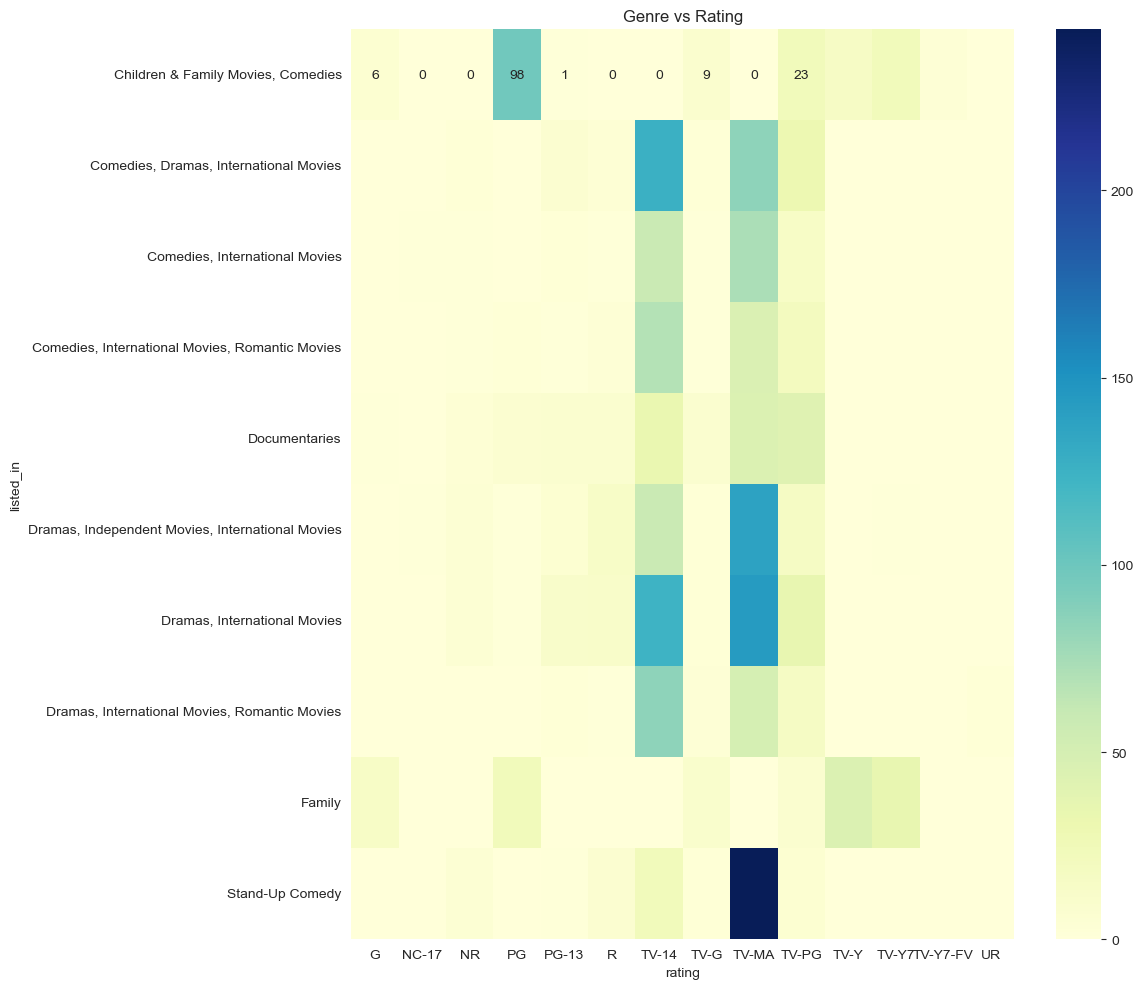

In [22]:
# correlation between genres and rating

# Create a DataFrame with genre and rating columns
genre_rating_df = df[['listed_in', 'rating']]
# with the top 10 genres
top_genres = genre_rating_df['listed_in'].value_counts().head(10).index

# Filter the DataFrame for the top 10 genres
genre_rating_df = genre_rating_df[genre_rating_df['listed_in'].isin(top_genres)]
# Pivot the DataFrame
genre_rating_pivot = genre_rating_df.pivot_table(index='listed_in', columns='rating', aggfunc=len, fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(genre_rating_pivot, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Genre vs Rating')
plt.tight_layout()
plt.show()


### Language Modeling and genre prediction

```{python}

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

data_desc = data_desc.reset_index(drop=True)

# Optionally, remove duplicate rows if necessary
data_desc = data_desc.drop_duplicates()
data_desc['combined_features'] = data_desc['description'] + ' ' + data_desc['country'].fillna('') + ' ' + data_desc['rating'].fillna('')

# Set X and y using the exploded DataFrame
X = data_desc['combined_features']
y = data_desc['listed_in']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Encode the target variable (genres)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a pipeline with TF-IDF and RandomForestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.8)),  # Use bigrams and trigrams
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))  # Multinomial Naive Bayes
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
'''

Accuracy: 0.22